# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

import seaborn as sb
sb.set()

#Ignoring warnings, such as deprecation warnings
import warnings
warnings.filterwarnings('ignore')

## Reading data

The Heart Disease dataset includes a set of features, such as patient age, chest pain type, and maximum heart rate. Whether the patient has heart disease or not is stored in the "target" feature.

The Dataset.info file has a more detailed description of the dataset.

In [2]:
dfraw = pd.read_csv("heart.csv")

#Ca should only have values from 0 to 3, not 4. Removing those samples
dfraw=dfraw[dfraw.ca!=4]
dfraw.reset_index(drop=True, inplace=True)

print("Sample count:\n", dfraw.shape[0])

print("Unique values per feature:")
for l,s in dfraw.items():
    print("-", l, s.nunique())

#Settings scalars and cetagorical features manually based on prior data knowledge
scalars=["age", "trestbps", "chol", "thalach", "oldpeak"]
cats=["cp", "restecg", "slope", "ca", "thal"]
targetFeature="target"

dfraw.head()

Sample count:
 298
Unique values per feature:
- age 41
- sex 2
- cp 4
- trestbps 49
- chol 152
- fbs 2
- restecg 3
- thalach 91
- exang 2
- oldpeak 40
- slope 3
- ca 4
- thal 4
- target 2


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

## Feature cleanup

Categorical features need to be turned into one-hot dummy values so that the machine learning algorithms don't assume there to be a linear relationship between the categories. Furthermore the first dummy column for each feature is removed. If none of the dummy columns of the feature are set to 1, then the first category (feature not present) is implied.

Data normalization smushes scalar features so that all of them are within a similar range of values regardless of the original scale of the values. This is required by many algorithms and even some visualisation techniques.

In [3]:
#Categorical features to dummies
df=dfraw
df = pd.get_dummies(df, columns=cats)

#Removing dummy traps (first dummy category of each feature)
dummyTraps = []
for c in cats:
    dummyTraps.append(c+"_0")
df.drop(dummyTraps, axis=1, inplace=True)

#Normalizing data
dfNorm = pd.DataFrame(preprocessing.scale(df[scalars]), columns=scalars)
df[scalars] = dfNorm
df.head()

age  sex  trestbps      chol  fbs   thalach  exang   oldpeak  target  \
0  0.941719    1  0.760757 -0.268426    1  0.023254      0  1.070920       1   
1 -1.942248    1 -0.089602  0.059722    0  1.635789      0  2.103438       1   
2 -1.498561    0 -0.089602 -0.828207    0  0.982058      0  0.296531       1   
3  0.165266    1 -0.656507 -0.210517    0  1.243550      0 -0.219728       1   
4  0.276188    0 -0.656507  2.067213    0  0.589820      1 -0.391814       1   

   cp_1  ...  restecg_1  restecg_2  slope_1  slope_2  ca_1  ca_2  ca_3  \
0     0  ...          0          0        0        0     0     0     0   
1     0  ...          1          0        0        0     0     0     0   
2     1  ...          0          0        0        1     0     0     0   
3     1  ...          1          0        0        1     0     0     0   
4     0  ...          1          0        0        1     0     0     0   

   thal_1  thal_2  thal_3  
0       1       0       0  
1       0       1       0  
2       0       1       0  
3       0       1       0  
4       0       1       0  

[5 rows x 22 columns]

# Data understanding

## Feature correlation matrix

The feature correlation matrix shows which, if any, pairs of features are correlated. Pairs with positive correlation often change in the same direction while pairs with negative correlation often change in opposite directions. 

Correlation doesn't equate to causation. Domain knowledge will help making educated decisions on which features actually have a relation of one kind or another.

This dataset doesn't have clear examples of positive correlation. A feature always has maximal correlation with itself, so the diagonal row of 1s does not count.

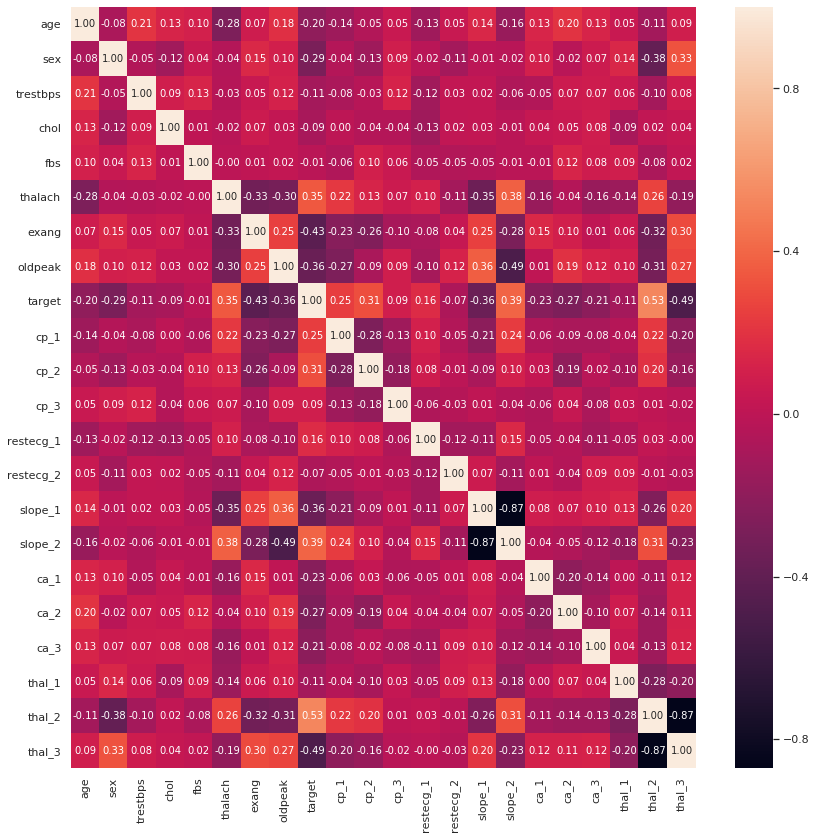

In [4]:
corr=df.corr("kendall")

f, ax = plt.subplots(figsize=(14,14))
sb.heatmap(corr, annot=True, fmt="0.2f", linewidths=0, ax=ax);

## Parallel plots

The parallel plot shows the distribution of samples for each class and each feature. It can be used to easily see if there is clear separation between the classes when it comes to a certain feature.

As seen below, this time there are no such features.

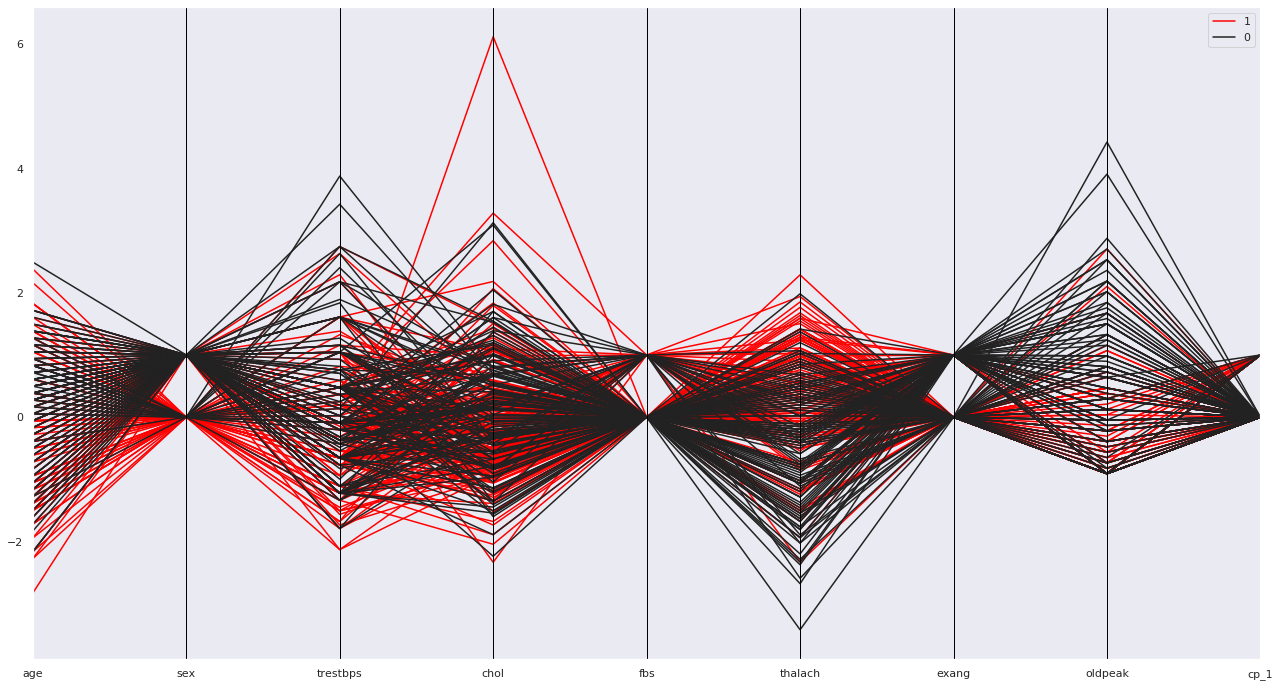

In [5]:
#Class colors
c1="#FF0000"
c2="#222222"

#Parallel plot for the first 10 features
f, ax = plt.subplots(figsize=(22,12))
pd.plotting.parallel_coordinates(df.iloc[:,0:10],"target",color=[c1,c2])
plt.show()

## Feature selection

Scikit-learn has many easy to use feature selection algorithms. Let's look at one of them.

The recursive feature elimination (RFE) algorithm uses a linear model, such as a support vector classifier (SVC), to find which features contribute to the result the most. These features are kept while others are recursively removed until a certain feature count is reached. In this case half of the features are kept.

The cross-validated RFE applies cross validation at each step of the feature elimination process to more accurately model how different features contribute to the result.

With such a small dataset feature selection might not improve the model performance, but we'll see.

In [6]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.svm import SVC

#Training data split
X = df.drop(targetFeature, axis=1)
y = df[targetFeature]

#Linear model
estimator = SVC(kernel="linear")

#Feature selection
selector = RFECV(estimator, 1, int(len(X.columns)/2), cv=5)
selector = selector.fit(X, y)
RFECV_features = X.columns[selector.support_]

selector = RFE(estimator, int(len(X.columns)/2), step=1)
selector = selector.fit(X, y)
RFE_features = X.columns[selector.support_]

#Stats
def FeatureStats(title, features):
    print(title)
    print(f"Feature count: {len(features)} ({len(features)/len(X.columns)*100:.2f}%)")
    print()

FeatureStats("All features", X.columns)
FeatureStats("RFE features", RFE_features)
FeatureStats("RFECV features", RFECV_features)

All features
Feature count: 21 (100.00%)

RFE features
Feature count: 10 (47.62%)

RFECV features
Feature count: 13 (61.90%)



# Modeling

In [7]:
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier

## Feature sets

The feature sets used in modeling are based on different subsets of the data. Baseline performance is given by the "All features" set which the subsets selected with RFE are compared to.

The "Two features" set only exists to show how poorly the models perform with only  two arbitrarily selected features.

In [8]:
#Target set is always the same
y=df[targetFeature]

#Titles
Ts=[
    "All features",
    "Two features",
    "RFE features",
    "RFECV features",
]

#Training sets
Xs=[
    df.drop(targetFeature, axis=1),
    df[[df.columns[2], df.columns[4]]],
    df[RFE_features],
    df[RFECV_features]
]

## Nested cross-validation

For small datasets splitting the data randomly into training and test sets reduces the amount of data available for training the model. Additionally, the randomness makes it harder to ascertain if the model has good performance or not.

Cross validation goes around these issues by using a neat trick to leverage the whole test set for training. The data is split into folds and each fold is used once for testing while the other folds serve as training data. The average performance score is calculated to find out how well the model did.

This score does not indicate how well the model would perform on unseen data, but rather how well it does based on the hyperparameters of the model, i.e. does it underfit or overfit? In both cases the average score will be low, as an overfitting model has eratic scores in each iteration and an underfitting model simply has low scores in all iterations.

Nested cross-validation first selects between different hyperparameters (in the inner loop) and then tests on unused validation sets (in the outer loop) for a final score. This can take a lot of time due to combinatorial explosion, yet in this case it should not take too long.

In [9]:
def NestedCrossValidation(estimator, X, y, params):
    #Stratification keeps the amount of classes in the train/test set split even.
    #A constant random_state makes sure each algorithm is tested with the same folds.
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

    # Inner CV for hyperparameter optimization.
    clf = GridSearchCV(estimator=estimator, param_grid=params, cv=inner_cv)

    # Outer CV for validated score
    scores = cross_validate(clf, X=X, y=y, cv=outer_cv)
    
    print("Nested CV score:", scores["test_score"].mean())

## K nearest neighbors classifier

K-nn is a universal learning method meaning it can model an arbitrary decision boundary between the classes. 

K-nn doesn't actually create a mathematical model based on the data. Instead, it runs through the samples looking for similar neighbors, which is to say, it takes a lot of memory (the whole dataset) to use. Unfortunately a lot of samples are often required for good performance as well, so the practical use cases are limited.

K-nn is a good benchmark/baseline algorithm to test against more complicated algorithms, but not great for deployment.

In [10]:
#K of 1 overfits maximally, k of len(X) underfits maximally.
#Let's search for the first 30 and leave it at that.
knnParams = {"n_neighbors":np.arange(2, 30, 1)}

#Running nested cv for all the feature sets
for title, X in zip(Ts,Xs):
    print("* K-nn:",title)
    
    NestedCrossValidation(KNeighborsClassifier(), X, y, knnParams)
    print()

* K-nn: All features
Nested CV score: 0.7987005649717515

* K-nn: Two features
Nested CV score: 0.5636723163841808

* K-nn: RFE features
Nested CV score: 0.8151977401129944

* K-nn: RFECV features
Nested CV score: 0.8189265536723165



## Ridge classifier

The ridge regression algorithm is among the simplest linear models out there.
It fits a hyperplane between the data by trying to keep all samples as close to the plane as possible. In other words, it minimizes a sum of squared error values.

Ridge regression includes a regularizer to keep the error minimizer from overfitting. This regularizer is controller with a hyperparameter called alpha. Low alpha allows the error minimizer to overfit, while high alpha causes the model to underfit. In nested cross-validation different alpha values are tested to find the best one for the data.

While originally meant for regression, a binary classification problem can be solved using the same algorithm with a few modifications. Scikit-learn provides such a version: RidgeClassifier.

In [11]:
#30 alpha values on a logarithmic scale
ridgeParams = {"alpha":np.geomspace(0.001,10, 30)}

#Running nested cv for all the training sets
for title, X, in zip(Ts,Xs):
    print("* Ridge:", title)
    
    NestedCrossValidation(RidgeClassifier(normalize=True), X, y, ridgeParams)
    print()

* Ridge: All features
Nested CV score: 0.8355367231638418

* Ridge: Two features
Nested CV score: 0.5705084745762713

* Ridge: RFE features
Nested CV score: 0.8388700564971752

* Ridge: RFECV features
Nested CV score: 0.8457062146892655



## Support vector classifier

Support vector classification hails from the same family of linear regressors as ridge, but it can perform non-linear modeling with kernels.

Kernels modify the dataset to include non-linear versions of the features (for instance, different polynomials). This allows a linear regressor to find non-linear surfaces in the sample space.

As with ridge, there is a hyperparameter which controls error regularisation. Unlike the alpha value, the C value inversely affects the regularisation strength. When using nested cross-validation this factoid has no importance.

In [12]:
#Running nested cv for all the training sets
for title, X in zip(Ts,Xs):
    print("* SVC:", title)
    
    #10 C values on a logarithmic scale and up to 10 degrees of polynomials
    maxDegree = min(10, X.shape[1])
    svcParams={"C":np.geomspace(0.001,10, 10), "degree": np.arange(2, maxDegree+1, 1)}
    
    NestedCrossValidation(SVC(kernel='poly', gamma="scale"), X, y, svcParams)
    print()

* SVC: All features
Nested CV score: 0.8022033898305085

* SVC: Two features
Nested CV score: 0.5402824858757062

* SVC: RFE features
Nested CV score: 0.7985875706214689

* SVC: RFECV features
Nested CV score: 0.8321468926553672



# Final model

Out of these three basic machine learning algorithms, the linear ridge classifier did the best. Close to 85% accuracy is not great by many standards, but it does beat flipping a coin. When it comes to predicting heart disease you better consult a doctor, though.

Nonetheless, which model was actually the best? The nested cross-validator searched for the best hyperparameter and then verified the result. Which model was this? Let's find out.

In [13]:
#The RFECV features were the best fit
X=df[RFECV_features]

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

# Inner CV for parameter optimization.
clf = GridSearchCV(estimator=RidgeClassifier(), param_grid=ridgeParams, cv=inner_cv)

# Outer CV for validated score
scores = cross_validate(clf, X=X, y=y, cv=outer_cv, return_estimator = True)
    
#With return_estimator set to True, the best inner GridSearchCV estimator can be found.
maxI = np.argmax(scores["test_score"])
bestCV = scores["estimator"][maxI]

#And the best model lies within
bestModel = bestCV.best_estimator_
print("Best model:", bestModel)
print("Best score:", bestCV.best_score_)

# Might as well test the best model one last time to make sure the stats don't lie.
score = cross_validate(bestModel, X=X, y=y, cv=outer_cv)

print("\nBest score recalculated:", score["test_score"].mean())

Best model: RidgeClassifier(alpha=10.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)
Best score: 0.836968085106383

Best score recalculated: 0.8489830508474576


Lastly, now that the best model, i.e. best algorithm and hyperparameters, has been found, it can be retrained with all of the data, not just partial data as is the case in cross-validation.

In [14]:
bestModel.fit(Xs[0], y)

RidgeClassifier(alpha=10.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

This model can then be tried on new, unseen data out in the real world. Well, if it was put into production.

## Mathematical model

Earlier it was revealed that the K-nn algorithm does not model anything mathematically. It requires the full dataset to make predictions. The ridge classifier algorithm, and most other machine learning algorithms, on the other hand, can be stored very efficiently after being trained.

When it comes to ridge, all it does is learn a set of weights, called coefficients, which when multiplied with a feature vector yield a prediction. Here they are:

In [15]:
print(bestModel.coef_)

[[ 0.01244434 -0.27945978 -0.06268584 -0.03562857  0.04626548  0.11210338
  -0.20548815 -0.12646171  0.20430866  0.34863841  0.33073648  0.09720998
  -0.03856105 -0.15630136  0.08904015 -0.38181046 -0.4565875  -0.32643312
   0.03409015  0.24265467 -0.22302893]]


One value per feature. It does not take a lot of memory to store them.